In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
db_path = Path('../Downloads/hawaii.sqlite')

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(f'sqlite:///{db_path}')

In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [11]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for col in measurement_columns: 
    print(col['name'])

id
station
date
prcp
tobs


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date_result = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_result

('2017-08-23',)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_str = most_recent_date_result[0]
most_recent_date = dt.datetime.strptime(most_recent_date_str, "%Y-%m-%d").date()


# Calculate the date one year from the last date in data set.
begining_date = most_recent_date - dt.timedelta(days=365)
print(begining_date)


# Perform a query to retrieve the data and precipitation scores
precipitation_query = session.query(Measurement.prcp, Measurement.date)\
.filter(Measurement.date >= begining_date).filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_query, columns=["precipitation","date"])


# Sort the dataframe by date
sorted_precipitation_df = precipitation_df.sort_values(by="date")

2016-08-23


Text(0, 0.5, 'Inches')

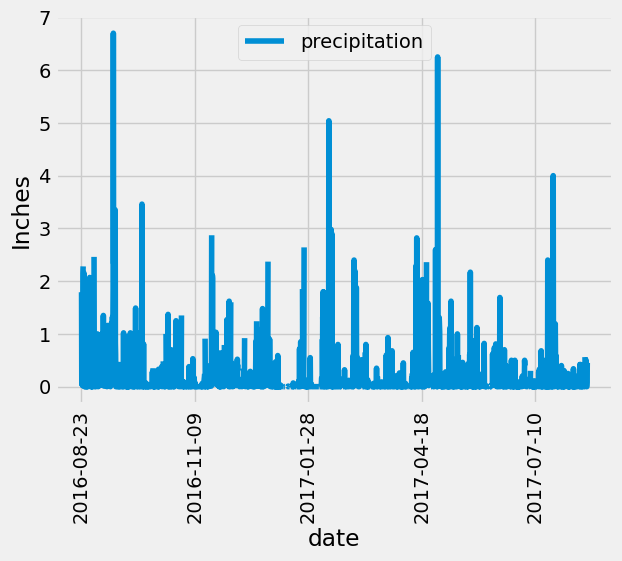

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_precipitation_df.plot(x="date", y="precipitation", rot=90)
plt.ylabel("Inches")


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:

#getting the list of columns in the Station table:
station_column = inspector.get_columns("station")
for col in station_column:
    print(col["name"])

id
station
name
latitude
longitude
elevation


In [17]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Station.station).count()
number_of_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#most active stations
most_active_station = active_stations[0]
most_active_station

('USC00519281', 2772)

In [20]:
#anothor way of finding the most active station
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

('USC00519281', 2772)

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == "USC00519281").all()
if result:
    min_temp, max_temp, avg_temp = result[0]
    print(f"Min Temp: {min_temp}, Max Temp: {max_temp}, Avg Temp: {avg_temp}")
else:
    print("No data found for the specified station.")

Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.66378066378067


In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tob_12_months = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == "USC00519281")\
.filter(Measurement.date >= begining_date).filter(Measurement.date <= most_recent_date).all()
df = pd.DataFrame(tob_12_months)
df

,tobs,date
0,77.0,2016-08-23
1,77.0,2016-08-24
2,80.0,2016-08-25
3,80.0,2016-08-26
4,75.0,2016-08-27
...,...,...
347,77.0,2017-08-14
348,77.0,2017-08-15
349,76.0,2017-08-16
350,76.0,2017-08-17


Text(0.5, 0, 'Tempreture')

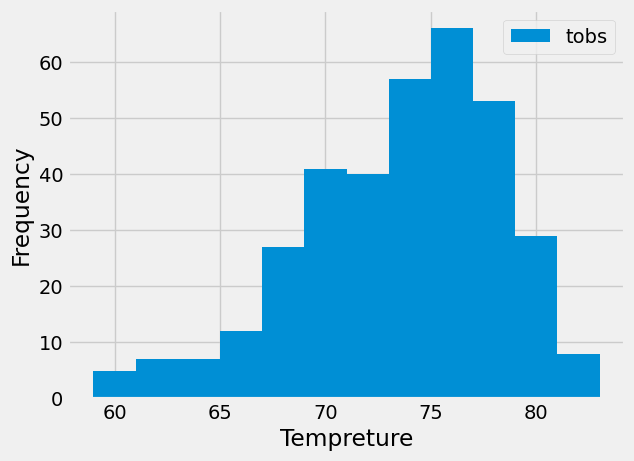

In [23]:
df.plot.hist(bins=12)
plt.xlabel('Tempreture')

# Close Session

In [24]:
# Close Session
session.close()